In [2]:
%load_ext watermark
%watermark -v -n -m -p numpy,scipy,sklearn,pandas

Sat Sep 15 2018 

CPython 3.6.6
IPython 6.5.0

numpy 1.15.1
scipy 1.1.0
sklearn 0.19.1
pandas 0.23.4

compiler   : GCC 4.8.2 20140120 (Red Hat 4.8.2-15)
system     : Linux
release    : 4.15.0-33-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import nolds
import data
import mne

PROJ_ROOT = os.path.abspath(os.path.join(os.pardir))
DATA_ROOT = os.path.abspath(os.path.join(PROJ_ROOT, 'data'))
PROCESSED_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'processed'))
RAW_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'raw'))
LABELED_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'labeled'))
DURATIONS_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'durations'))
print(PROJ_ROOT)
print(DATA_ROOT)
print(PROCESSED_ROOT)
import sys
sys.path.append(os.path.join(PROJ_ROOT, 'src'))
CHANNEL_NAMES = ('FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
                 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz')
META_COLUMN_NAMES = ['freq', 'RESP_4W', 'RESP_FIN', 'REMISE_FIN', 'AGE', 'SEX', 'M_1',
       'M_4', 'M_F', 'délka léčby', 'lék 1', 'lék 2', 'lék 3', 'lék 4']
META_FILE_NAME = 'DEP-POOL_Final_144.xlsx'
meta_df = pd.read_excel(os.path.join(RAW_ROOT, META_FILE_NAME), index_col='ID', names=META_COLUMN_NAMES)

raw_fif = mne.io.read_raw_fif(os.path.join(PROCESSED_ROOT, '1a.fif'))
t = pd.DataFrame(raw_fif.get_data())
data = pd.DataFrame(np.transpose(t.values), columns=CHANNEL_NAMES)
data = np.transpose(data.values)
metapkl = pd.read_pickle(os.path.join(LABELED_ROOT, 'processed', 'meta', 'meta.pkl'))

/home/kovar/thesis_project
/home/kovar/thesis_project/data
/home/kovar/thesis_project/data/processed
Opening raw data file /home/kovar/thesis_project/data/processed/1a.fif...
This filename (/home/kovar/thesis_project/data/processed/1a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 19104 =      0.000 ...    76.416 secs
Ready.


<ipython-input-2-189a96e9ba82>:29: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/1a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(os.path.join(PROCESSED_ROOT, '1a.fif'))


Creating RawArray with float64 data, n_channels=19, n_times=19105
    Range : 0 ... 19104 =      0.000 ...    76.416 secs
Ready.
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


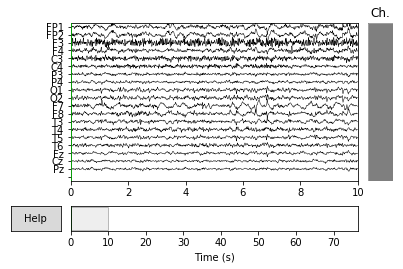

/home/kovar/miniconda3/envs/thesis/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


In [55]:
import mne
names = ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 
         'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']

raw_root = os.path.abspath(os.path.join(DATA_ROOT, 'raw'))
filename = '1a.tdt'
df = pd.read_table(os.path.join(raw_root, filename), sep='\t', names=names, skiprows=[0])

info = mne.create_info(ch_names=names, sfreq=250, ch_types='eeg')
data = mne.io.RawArray(np.transpose(df.values), info)

data.set_eeg_reference('average', projection=True)  # set EEG average reference
data.apply_proj()
fig = data.plot(block=True, lowpass=40, scalings='auto', show_options=False)
# fig.set_size_inches(1, forward=True)
fig.show()

In [2]:
def f(row, col):
    if row[col] <= 16:
        return -1
    if row[col] <= 28:
        return 0
    else:
        return 1
def ff(row, col, n=5):
    for i in range(n):
        if row[col] <= metapkl.quantile((i+1)/n)[col]:
            return i
    
metapkl['dep'] = metapkl.apply(lambda row: f(row, 'sc'), axis=1)
metapkl['dep_bef'] = metapkl.apply(lambda row: f(row, 'sc_bef'), axis=1)
metapkl['dep_aft'] = metapkl.apply(lambda row: f(row, 'sc_aft'), axis=1)
metapkl = metapkl.astype({'dep': 'category', 'dep_bef': 'category', 'dep_aft': 'category'})                                           
print(metapkl['dep'].value_counts())
print(metapkl['dep_bef'].value_counts())
print(metapkl['dep_aft'].value_counts())

def f(row, col):
    if row[col] <= metapkl.loc[(slice(None), 'a'), :].quantile(0.42)['change']:
        return -1
    if row[col] <= metapkl.loc[(slice(None), 'a'), :].quantile(0.56)['change']:
        return 0
    else:
        return 1
    
metapkl['resp'] = metapkl.apply(lambda row: f(row, 'change'), axis=1)
metapkl = metapkl.astype({'resp': 'category'})                                           
print(metapkl.loc[(slice(None), 'a'), 'resp'].value_counts())

 0    148
-1     62
 1     56
Name: dep, dtype: int64
0    170
1     96
Name: dep_bef, dtype: int64
 0    126
-1    124
 1     16
Name: dep_aft, dtype: int64
 1    59
-1    57
 0    17
Name: resp, dtype: int64


In [15]:
meta_df

,freq,RESP_4W,RESP_FIN,REMISE_FIN,AGE,SEX,M_1,M_4,M_F,délka léčby,lék 1,lék 2,lék 3,lék 4
ID,,,,,,,,,,,,,,
1,250,1,1,0,49,0,26,13,13,4,milnacipram,NaN,NaN,NaN
2,250,0,0,0,36,0,31,30,30,4,bupropion,NaN,NaN,NaN
3,250,1,1,1,48,0,25,7,7,5,sertralin,trazodon,NaN,NaN
4,250,0,0,0,55,0,26,25,25,4,rTMS,clonazepam,NaN,NaN
5,250,0,0,0,35,0,26,37,37,4,rTMS,mirtazapin,cilalopram,chlorprothixen
6,250,0,0,0,37,0,31,17,26,6,escitalopram,NaN,NaN,NaN
7,250,0,0,0,63,0,30,25,25,4,rTMS,mirtazapin,quetiapin,escitalopram
8,250,1,1,1,50,1,24,11,11,4,rTMS,dosulepin,esctitalopram,NaN
9,250,0,0,0,59,1,34,27,27,4,rTMS,milnacipran,NaN,NaN


/home/kovar/miniconda3/envs/thesis/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


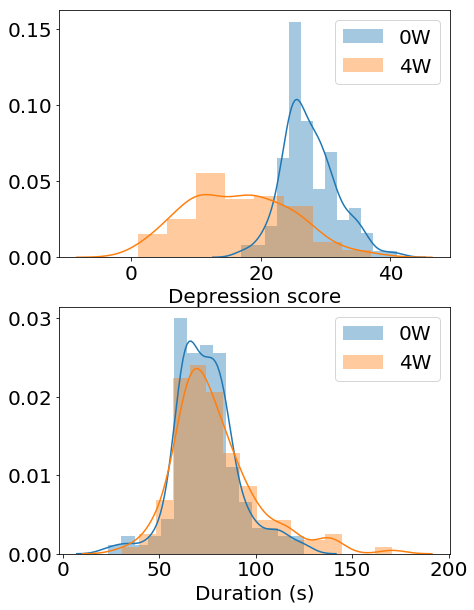

In [3]:
fig, ax = plt.subplots(2, 1, figsize=(7,10), sharex=False, sharey=False)
sns.distplot(meta_df['M_1'], ax=ax[0], label='0W')
sns.distplot(meta_df['M_4'], ax=ax[0], label='4W')
ax[0].set_xlabel('Depression score', fontsize=20)
ax[0].legend(fontsize=20)
ax[0].tick_params(axis='x', labelsize=20)
ax[0].tick_params(axis='y', labelsize=20)

durs = pd.read_csv(os.path.join(DATA_ROOT, 'durations', 'durations.csv'), sep='\t', index_col=0)
durs_bef = durs[list(map(lambda idx: idx.startswith('a'), durs.index))]
durs_aft = durs[list(map(lambda idx: idx.startswith('b'), durs.index))]
sns.distplot(durs_bef['duration_s'], ax=ax[1], label='0W')
sns.distplot(durs_aft['duration_s'], ax=ax[1], label='4W')
ax[1].set_xlabel('Duration (s)', fontsize=20)
ax[1].legend(fontsize=20)
ax[1].tick_params(axis='x', labelsize=20)
ax[1].tick_params(axis='y', labelsize=20)

plt.show()

/home/kovar/miniconda3/envs/thesis/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


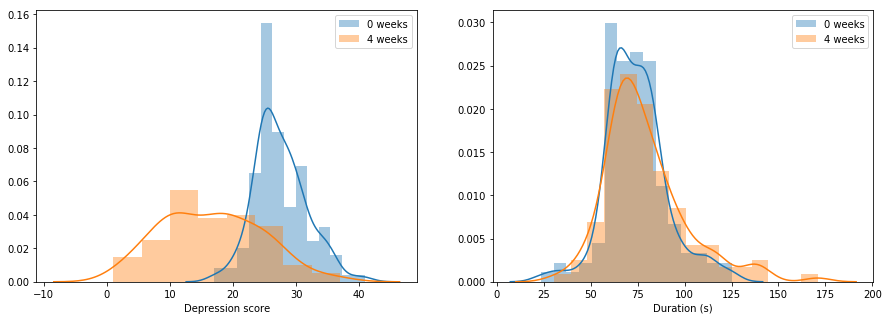

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(15,5), sharex=False, sharey=False)
sns.distplot(meta_df['M_1'], ax=ax[0], label='0 weeks')
sns.distplot(meta_df['M_4'], ax=ax[0], label='4 weeks')
ax[0].set_xlabel('Depression score')
ax[0].legend()

durs = pd.read_csv(os.path.join(DATA_ROOT, 'durations', 'durations.csv'), sep='\t', index_col=0)
durs_bef = durs[list(map(lambda idx: idx.startswith('a'), durs.index))]
durs_aft = durs[list(map(lambda idx: idx.startswith('b'), durs.index))]
sns.distplot(durs_bef['duration_s'], ax=ax[1], label='0 weeks')
sns.distplot(durs_aft['duration_s'], ax=ax[1], label='4 weeks')
ax[1].set_xlabel('Duration (s)')
ax[1].legend()

plt.show()

/home/kovar/miniconda3/envs/thesis/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


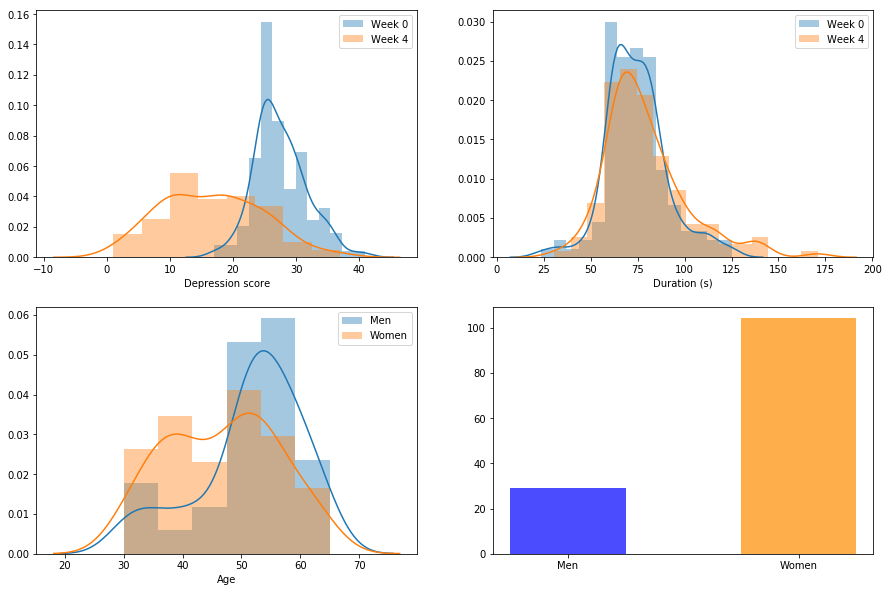

In [68]:
fig, ax = plt.subplots(2, 2, figsize=(15,10), sharex=False, sharey=False)
sns.distplot(meta_df['M_1'], ax=ax[0,0], label='Week 0')
sns.distplot(meta_df['M_4'], ax=ax[0,0], label='Week 4')
ax[0,0].set_xlabel('Depression score')
ax[0,0].legend()

durs = pd.read_csv(os.path.join(DATA_ROOT, 'durations', 'durations.csv'), sep='\t', index_col=0)
durs_bef = durs[list(map(lambda idx: idx.startswith('a'), durs.index))]
durs_aft = durs[list(map(lambda idx: idx.startswith('b'), durs.index))]
sns.distplot(durs_bef['duration_s'], ax=ax[0,1], label='Week 0')
sns.distplot(durs_aft['duration_s'], ax=ax[0,1], label='Week 4')
ax[0,1].set_xlabel('Duration (s)')
ax[0,1].legend()

sns.distplot(meta_df[meta_df['SEX']==1]['AGE'], ax=ax[1,0], label='Men')
sns.distplot(meta_df[meta_df['SEX']==0]['AGE'], ax=ax[1,0], label='Women')
ax[1,0].set_xlabel('Age')
ax[1,0].legend()

women = meta_df[meta_df['SEX'] == 0]['SEX'].count()
men = meta_df[meta_df['SEX'] == 1]['SEX'].count()
# plt.figure(figsize=(5,5))
ax[1,1].bar(('Men', 'Women'), (men, women), 0.5, color=('blue', 'darkorange'), alpha=0.7)

plt.show()

In [14]:
durs = pd.read_csv(os.path.join(DATA_ROOT, 'durations', 'durations.csv'), sep='\t', index_col=0)
durs_bef = durs[list(map(lambda idx: idx.startswith('a'), durs.index))]
durs_aft = durs[list(map(lambda idx: idx.startswith('b'), durs.index))]

Index(['a-1', 'a-10', 'a-100', 'a-101', 'a-102', 'a-103', 'a-104', 'a-105',
       'a-106', 'a-107',
       ...
       'b-90', 'b-91', 'b-92', 'b-93', 'b-94', 'b-95', 'b-96', 'b-97', 'b-98',
       'b-99'],
      dtype='object', length=266)

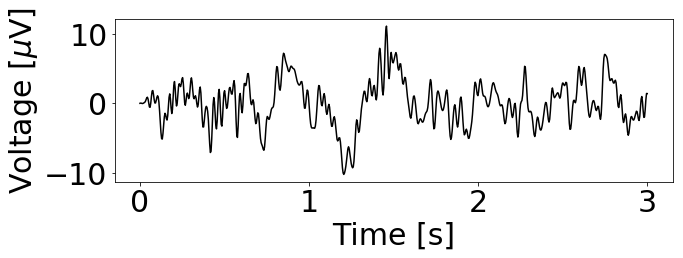

In [58]:
plt.figure(figsize=(10,3))
line = plt.plot(np.linspace(0, 3, 750), data[0][:750], color='black')
fontsize=30
plt.xlabel('Time [s]', fontsize=fontsize)
plt.ylabel(r'Voltage [$\mu$V]', fontsize=fontsize)
plt.tick_params(axis='x', labelsize=fontsize)
plt.tick_params(axis='y', labelsize=fontsize)
plt.show()

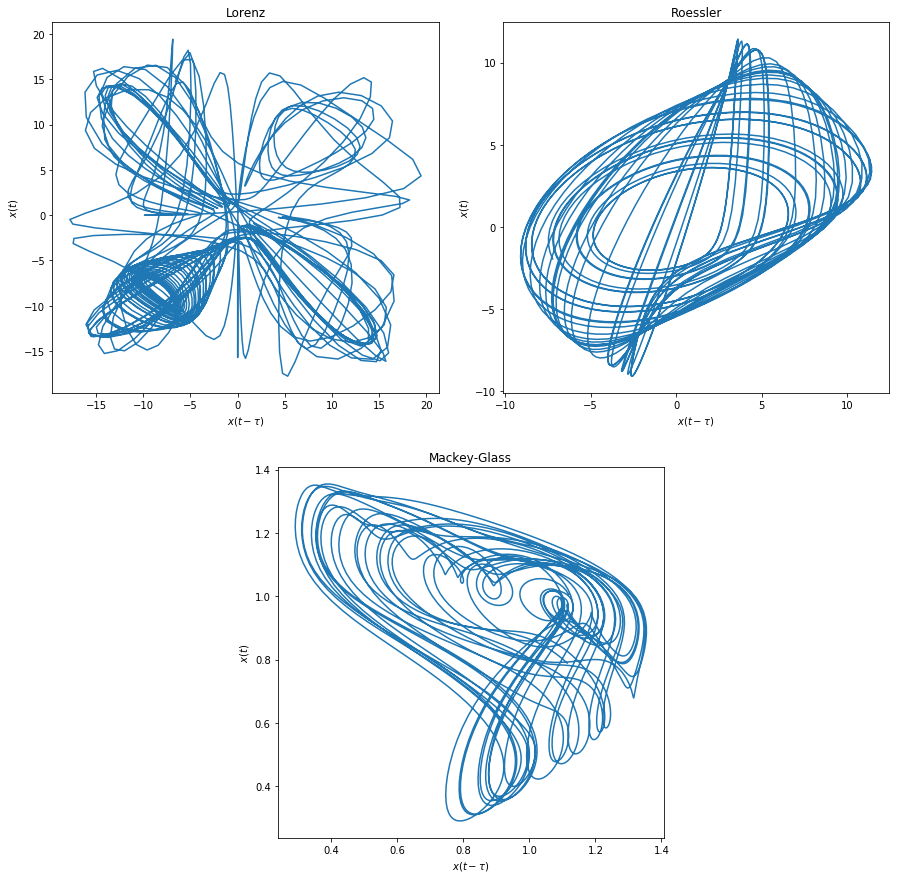

In [130]:
from lib.nolitsa.nolitsa import data

def plotx(x, ax, title=''):
    ax.set_title(title)
    ax.plot(x[50:], x[:-50])
    ax.set_xlabel(r'$x(t - \tau)$')
    ax.set_ylabel(r'$x(t)$')
    

# fig, ax = plt.subplots(2, 2, figsize=(10,10))

import matplotlib.gridspec as gridspec
plt.figure(figsize=(15,15))
gs = gridspec.GridSpec(2, 4, hspace=0.2, wspace=0.4)
ax1 = plt.subplot(gs[0, 0:2])
ax2 = plt.subplot(gs[0,2:])
ax3 = plt.subplot(gs[1,1:3])
fig = plt.gcf()
# gs.tight_layout(fig)

x = data.lorenz(length=2000)[1][:, 0]
plotx(x, ax1, 'Lorenz')

x = data.roessler(length=2000)[1][:, 0]
plotx(x, ax2, 'Roessler')

x = data.mackey_glass(length=3000)
plotx(x, ax3, 'Mackey-Glass')

# x = data.ikeda(length=500)[:, 0]
# plotx(x, ax[1,1], 'Ikeda')

# plt.tight_layout()
plt.show()